## Load libraries and data

In [298]:
import copy
import seaborn as sns
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import StackingClassifier
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import resample

from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV  

RANDOM_SEED = 8    # Set a random seed for reproducibility!

In [299]:
pd.set_option("display.max_columns", 100)

PATH = "Data/"

train_df = pd.read_csv(
    PATH + "train.csv", 
    index_col="PassengerId"
)
test_features_df = pd.read_csv(
    PATH + "test.csv", 
    index_col="PassengerId"
)

labels_df = train_df[['Survived']]
features_df = train_df.drop('Survived', axis=1)

labels_df.head()
features_df.head()
features_df.shape

(891, 10)

## Feature Enginnering

First we look at what are the numeric and catergorical columns in data

In [322]:
numeric_cols = features_df.columns[features_df.dtypes != 'object']
cat_cols = features_df.columns[features_df.dtypes == 'object']
print(numeric_cols, cat_cols)
features_df.head()

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin_N',
       'relatives', 'notAlone'],
      dtype='object') Index(['Name', 'Sex', 'Embarked', 'Cabin_L'], dtype='object')


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_L,Cabin_N,relatives,notAlone
PassengerId,,,,,,,,,,,,,
1,3,Mr,male,22.0,1,0,5.0,7.2500,S,NaN,NaN,1,1
2,1,Mrs,female,38.0,1,0,17599.0,71.2833,C,C,85.0,1,1
3,3,Miss,female,26.0,0,0,2.0,7.9250,S,NaN,NaN,0,0
4,1,Mrs,female,35.0,1,0,113803.0,53.1000,S,C,123.0,1,1
5,3,Mr,male,35.0,0,0,373450.0,8.0500,S,NaN,NaN,0,0


In [320]:
## Element vise operator functions
import re
def nameSplit(cabin):
    if isinstance(cabin, float):
        return cabin
    else:
        return cabin[0]
    
def idSplit(cabin):
    if isinstance(cabin, float):
        return cabin
    if isinstance(cabin, string_types):
        numbers = [int(s) for s in re.findall(r'-?\d+\.?\d*', cabin)]
        if len(numbers) > 0:
            return numbers[0]
        else:
            return np.nan

def ticketSplit(ticket):
    numbers = [float(s) for s in re.findall(r'-?\d+\.?\d*', ticket)]
    if len(numbers) > 0:
        return int(numbers[0])
    else:
        return np.nan

## column vise operators    
def namePrefix(dataFrame):
    new_df = copy.deepcopy(dataFrame)
    new_df["Name"] = dataFrame["Name"].apply(lambda x : "Mrs" if x.find("Mrs") != -1 
                                             else ("Miss" if x.find("Miss") != -1  
                                                          else "Mr"))
    return new_df

def separateCabin(dataFrame):
    new_df = copy.deepcopy(dataFrame)

    new_df["Cabin_L"] = dataFrame["Cabin"].apply(nameSplit)
    new_df["Cabin_N"] = dataFrame["Cabin"].apply(idSplit)
    new_df.drop('Cabin', inplace=True, axis=1)
    return new_df

def getTicketNumber(dataFrame):
    new_df = copy.deepcopy(dataFrame)
    new_df["Ticket"] = dataFrame["Ticket"].apply(ticketSplit)
    new_df["relatives"] = dataFrame["SibSp"] + dataFrame["Parch"]
    new_df["notAlone"] = new_df["relatives"].apply(lambda x : 0 if x == 0 else 1)
    return new_df

separateCabinTransformer = FunctionTransformer(separateCabin)
namePrefixTransformer = FunctionTransformer(namePrefix)
ticketTransformer = FunctionTransformer(getTicketNumber)

features_df = namePrefix(features_df)
features_df = separateCabin(features_df)
features_df = getTicketNumber(features_df)
features_df

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_L,Cabin_N,relatives,notAlone
PassengerId,,,,,,,,,,,,,
1,3,Mr,male,22.0,1,0,5.0,7.2500,S,NaN,NaN,1,1
2,1,Mrs,female,38.0,1,0,17599.0,71.2833,C,C,85.0,1,1
3,3,Miss,female,26.0,0,0,2.0,7.9250,S,NaN,NaN,0,0
4,1,Mrs,female,35.0,1,0,113803.0,53.1000,S,C,123.0,1,1
5,3,Mr,male,35.0,0,0,373450.0,8.0500,S,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,Mr,male,27.0,0,0,211536.0,13.0000,S,NaN,NaN,0,0
888,1,Miss,female,19.0,0,0,112053.0,30.0000,S,B,42.0,0,0
889,3,Miss,female,NaN,1,2,6607.0,23.4500,S,NaN,NaN,3,1


In [302]:
total = features_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
Cabin,687.0,77.1
Age,177.0,19.9
Embarked,2.0,0.2
Fare,0.0,0.0
Ticket,0.0,0.0
Parch,0.0,0.0
SibSp,0.0,0.0
Sex,0.0,0.0
Name,0.0,0.0
Pclass,0.0,0.0


## Visualisation

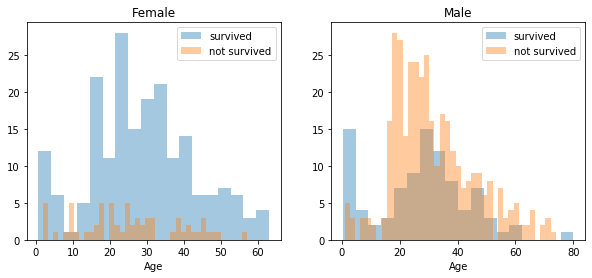

In [303]:
joined_df = features_df.join(labels_df)

survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

women = joined_df[train_df['Sex']=='female']
men = joined_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

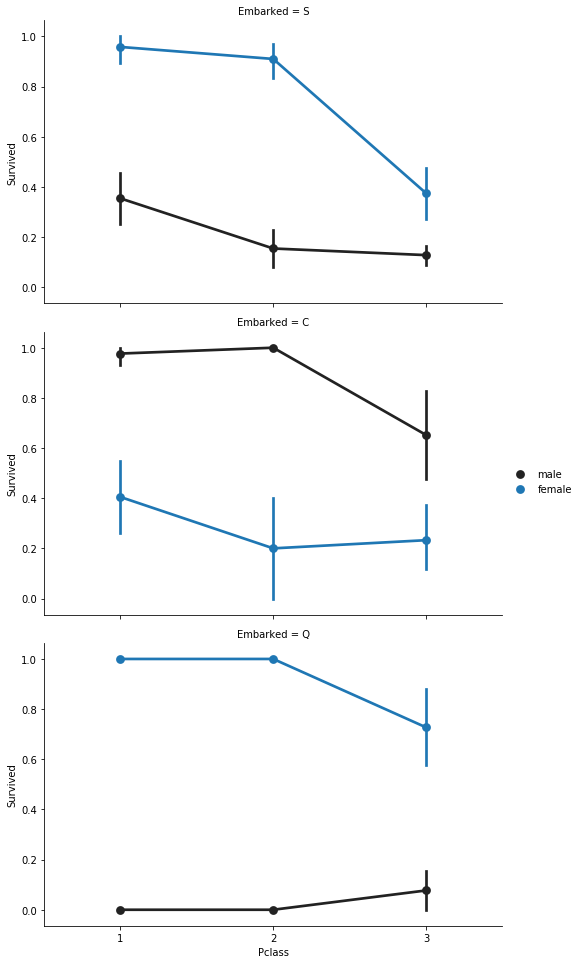

In [304]:
FacetGrid = sns.FacetGrid(joined_df, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

In [305]:
def plot_survive(col, target, data, ax=None):
    counts = (data[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

In [306]:
%matplotlib inline
import matplotlib.pyplot as plt

temp = separateCabin(features_df)
temp = namePrefix(temp)
temp = getTicketNumber(temp)
cols_to_plot = temp.columns[(temp.dtypes == 'object') | (temp.dtypes == 'int64')]
joined_df = temp.join(labels_df)
print(cols_to_plot)

Index(['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Cabin_L'], dtype='object')


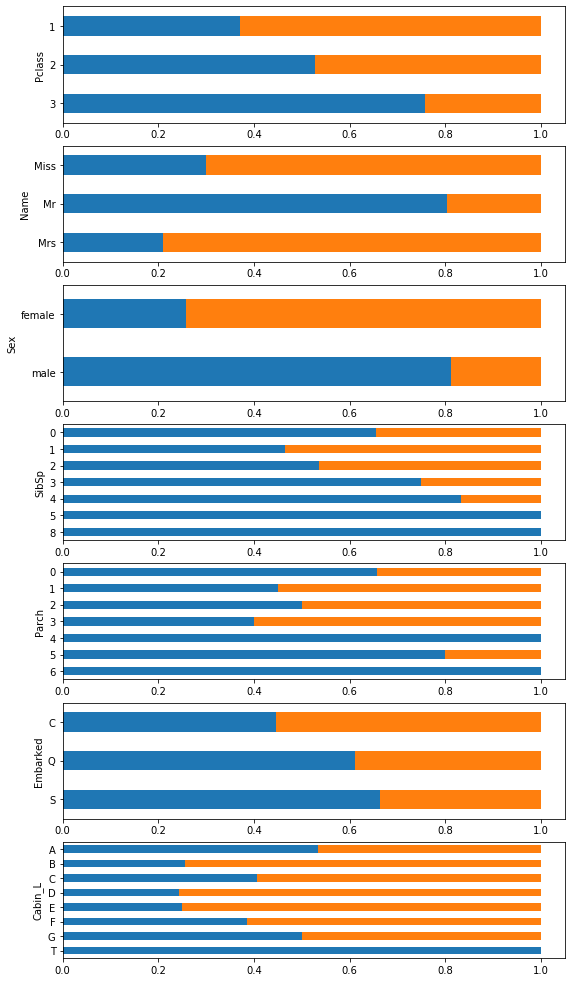

In [307]:
_, ax = plt.subplots(
    len(cols_to_plot), 1, figsize=(9,len(cols_to_plot)*2.5)
)

for idx, col in enumerate(cols_to_plot):
    plot_survive(
        col, 'Survived', joined_df, ax=ax[idx]
    )

In [308]:
# To compute correlation
#im = SimpleImputer(strategy='most_frequent')
#le = OrdinalEncoder()
#s1 = im.fit_transform(features_df[cat_cols])
#encoded = le.fit_transform(s1)

#encoded = pd.DataFrame(encoded, columns=cat_cols)

# join all the dataframe to compute correlations
#joined_df = features_df[numeric_cols].join(encoded).join(labels_df)
joined_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_L,Cabin_N,Survived
PassengerId,,,,,,,,,,,,
1,3,Mr,male,22.0,1,0,5.0,7.2500,S,NaN,NaN,0
2,1,Mrs,female,38.0,1,0,17599.0,71.2833,C,C,85.0,1
3,3,Miss,female,26.0,0,0,2.0,7.9250,S,NaN,NaN,1
4,1,Mrs,female,35.0,1,0,113803.0,53.1000,S,C,123.0,1
5,3,Mr,male,35.0,0,0,373450.0,8.0500,S,NaN,NaN,0


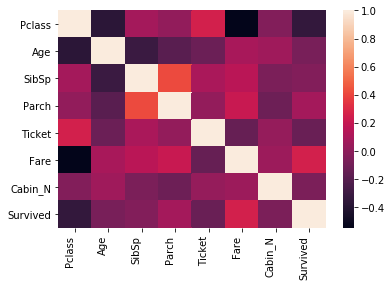

In [309]:
correlations = joined_df.corr()

ax = sns.heatmap(
    correlations
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [313]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    887 non-null    float64
 7   Fare      891 non-null    float64
 8   Embarked  889 non-null    object 
 9   Cabin_L   204 non-null    object 
 10  Cabin_N   200 non-null    float64
 11  Survived  891 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 130.5+ KB


## Classifiers

In [321]:
est_mlp = MLPClassifier(hidden_layer_sizes=(200,100,), learning_rate='invscaling', learning_rate_init=0.01,
                          power_t=0.5, max_iter=500, shuffle=True, tol=0.0001, 
                          early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, max_fun=15000,
                         random_state=RANDOM_SEED)
est_xgb = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, reg_lambda=30, reg_alpha=0)
est_gb = GradientBoostingClassifier(random_state=8, n_estimators=250)
est_rn = RandomForestClassifier(max_depth=10, bootstrap=True, n_estimators=200)
est_svc = SVC()
est_nb = GaussianNB()
est_kn = KNeighborsClassifier()

estimators_stacked = [('xbg', est_xgb),
              ('mlp', est_mlp),
             ]

stacked_estimator =  StackingClassifier(estimators=estimators_stacked,
                                    final_estimator=LogisticRegression(),
                                    stack_method='predict_proba'
                                  )

## Building the pipeline

In [328]:
seperate_processing_cols = ['Ticket']
cat_cols = [x for x in cat_cols if (x not in seperate_processing_cols)]
numeric_cols = [x for x in numeric_cols if (x not in seperate_processing_cols)]

print(numeric_cols, cat_cols)

numeric_preprocessing = Pipeline([
    ('Imputer', SimpleImputer()),
    ('Scaler', StandardScaler())
])

cat_preprocessing = Pipeline([
    #('name_transformer', namePrefixTransformer), 
    #('Cabin_transformer', separateCabinTransformer),
    ('Imputer', SimpleImputer(strategy='most_frequent')),
    ('Onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[('Numeric_preprocessing', numeric_preprocessing, numeric_cols),
                  ('Cat_preprocessing', cat_preprocessing, cat_cols)],
    remainder='drop'
)

full_pipeline = Pipeline([
    ('Preprocessor', preprocessor),
    ("estimator", est_rn)
])

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin_N', 'relatives', 'notAlone'] ['Name', 'Sex', 'Embarked', 'Cabin_L']


## Training and Evaluation

In [329]:

#splitting the dataset
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)


full_pipeline.fit(X_train, y_train)
print("Training done")

C:\Users\pgunarathna\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\pipeline.py:291: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)


Training done


In [330]:
y_pred_train= full_pipeline.predict(X_train)
y_pred= full_pipeline.predict(X_eval)

In [331]:
accuracy_score(y_train, y_pred_train)

0.9379194630872483

In [332]:
accuracy_score(y_eval, y_pred)

0.8169491525423729

In [212]:
%%time 

full_pipeline.fit(features_df, labels_df.values.ravel())

None   # So we don't print out the whole pipeline representation

Wall time: 690 ms


In [213]:
test_score = full_pipeline.predict(test_features_df)

In [215]:
y_preds = pd.DataFrame(
    {
        "Survived": test_score,
    },
    index = test_features_df.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (418, 1)


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [216]:
submission_df = pd.read_csv(PATH + "gender_submission.csv", 
                            index_col="PassengerId")

In [223]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)
# Save predictions to submission data frame
submission_df["Survived"] = test_score
submission_df.to_csv('my_submission.csv', index=True)